# Project 1 Linear Regression with Regularization
## Joseph Bentivegna

- Part 1: Closed form linear regression
- Part 2: Closed form linear regression with ridge regression
- Part 3: Sklearn implementation of linear regression with lasso regression

Dataset from: http://mlr.cs.umass.edu/ml/datasets/Auto+MPG

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# import data and drop unnecessary cols
df = pd.read_csv("auto-mpg.csv")
df = df[df['Horsepower'] != "?"]
del df['Name']
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [3]:
# # one-hot endode decrete columns
# cyl = df['Cylinders']
# year = df['Model Year']
# orig = df['Origin']
# cyl_hot = pd.get_dummies(cyl, prefix='Cylinders')
# year_hot = pd.get_dummies(year, prefix='Model_Year')
# orig_hot = pd.get_dummies(orig, prefix='Origin')

# df = pd.concat([df, cyl_hot, year_hot, orig_hot],axis=1)

# df = df.drop(['Cylinders', 'Model Year', 'Origin'], axis=1)

# df.head()

In [4]:
# divide dataset into train-val-test
train = df.sample(n=308)

rest_df = df[~df.index.isin(train.index)]

val = rest_df.sample(n=45)
test = rest_df[~rest_df.index.isin(val.index)]

train = train.reset_index(drop=True).astype(float)
val = val.reset_index(drop=True).astype(float)
test = test.reset_index(drop=True).astype(float)

print (len(df), len(train), len(test), len(val))

392 308 39 45


# Part A: Linear Regression

In [5]:
# concatenate column of 1's to first column in matrix
ones_train = np.ones([len(train),1])
ones_test = np.ones([len(test),1])
train_x = np.concatenate((ones_train, train.iloc[:,1:]),axis=1).astype(float)
test_x = np.concatenate((ones_test, test.iloc[:,1:]), axis=1).astype(float)
print (train_x.shape, ": shape of training data")
train_y = np.array([train.iloc[:,0]]).T
test_y = np.array([test.iloc[:,0]]).T
print (train_y.shape, ": shape of labels")

# calculate weights using closed form solution
w = np.linalg.inv(train_x.T@train_x)@(train_x.T@train_y)
print (w.shape, ": shape of weights")

# calculate y_hats from weights
y_hat = test_x@w

# compute mean squared error
mse = np.sum((test_y - y_hat)**2)/len(test_y)
print (np.round(mse,2), ": Mean Squared Error")

(308, 8) : shape of training data
(308, 1) : shape of labels
(8, 1) : shape of weights
12.45 : Mean Squared Error


# Part B: Linear Regression with Ridge Regression

In [6]:
def normalize(df):
    
    for ii in range(df.shape[1]):
        df[:,ii] = (df[:,ii]-np.mean(df[:,ii]))/np.std(df[:,ii])
    
    return df

In [7]:
def ridge(x, y, lam):

    lambIdent = lam*np.identity(len(x.T))
    inver = np.linalg.inv((x.T@x) + lambIdent)
    w = inver@x.T@y
    
    return w

In [8]:
# normalize inputs and labels
train_x = normalize(np.array(train.iloc[:,1:]))
val_x = normalize(np.array(val.iloc[:,1:]))
test_x = normalize(np.array(test.iloc[:,1:]))

train_y = normalize(np.array([train.iloc[:,0]]).T)
val_y = normalize(np.array([val.iloc[:,0]]).T)
test_y = normalize(np.array([test.iloc[:,0]]).T)

print (train_x.shape, ": shape of training data")
print (train_y.shape, ": shape of training labels")

lambs = [0.0001, 0.0004, 0.0007, 0.001, 0.004, 0.007, 0.01, 0.04, 0.07, 0.1, 0.5, 0.7]
mses = []

# iterate through lambdas to find minimum mse
for lamb in lambs:
    w = ridge(train_x, train_y, lamb)
    y_hat = val_x@w
    mse = np.sum((val_y - y_hat)**2)/len(val_y)
    mses.append(mse)

best_lamb = lambs[mses.index(min(mses))]
print (best_lamb, ": best lambda")

# re-train the model with the best lambda
w = ridge(train_x, train_y, best_lamb)
y_hat = test_x@w

# compute final mse
mse = np.sum((test_y - y_hat)**2)/len(test_y)
print (np.round(mse,2), ": Mean Squared Error")

(308, 7) : shape of training data
(308, 1) : shape of training labels
0.0001 : best lambda
0.23 : Mean Squared Error


# Part C: Linear Regression with Lasso Regression

In [9]:
# normalize inputs and labels
train_x = normalize(np.array(train.iloc[:,1:]))
val_x = normalize(np.array(val.iloc[:,1:]))
test_x = normalize(np.array(test.iloc[:,1:]))

train_y = normalize(np.array([train.iloc[:,0]]).T)
val_y = normalize(np.array([val.iloc[:,0]]).T)
test_y = normalize(np.array([test.iloc[:,0]]).T)

print (train_x.shape, ": shape of training data")
print (train_y.shape, ": shape of training labels")

lambs = [0.0001, 0.0004, 0.0007, 0.001, 0.004, 0.007, 0.01, 0.04, 0.07, 0.1, 0.5, 0.7]
mses = []

# iterate through lambdas to find minimum mse
for lamb in lambs:
    clf = linear_model.Lasso(alpha=lamb)
    clf.fit(train_x, train_y)
    y_hat = clf.predict(val_x)
    mse = np.sum((val_y.flatten() - y_hat.flatten())**2)/len(val_y)
    mses.append(mse)
    
best_lamb = lambs[mses.index(min(mses))]
print (best_lamb, ": best lambda")

# re-train the model with the best lambda
clf = linear_model.Lasso(alpha=best_lamb)
clf.fit(train_x, train_y)
y_hat = clf.predict(test_x)

# compute final mse
mse = np.sum((test_y.flatten() - y_hat.flatten())**2)/len(test_y)
print (np.round(mse,2), ": Mean Squared Error")

(308, 7) : shape of training data
(308, 1) : shape of training labels
0.0001 : best lambda
0.23 : Mean Squared Error


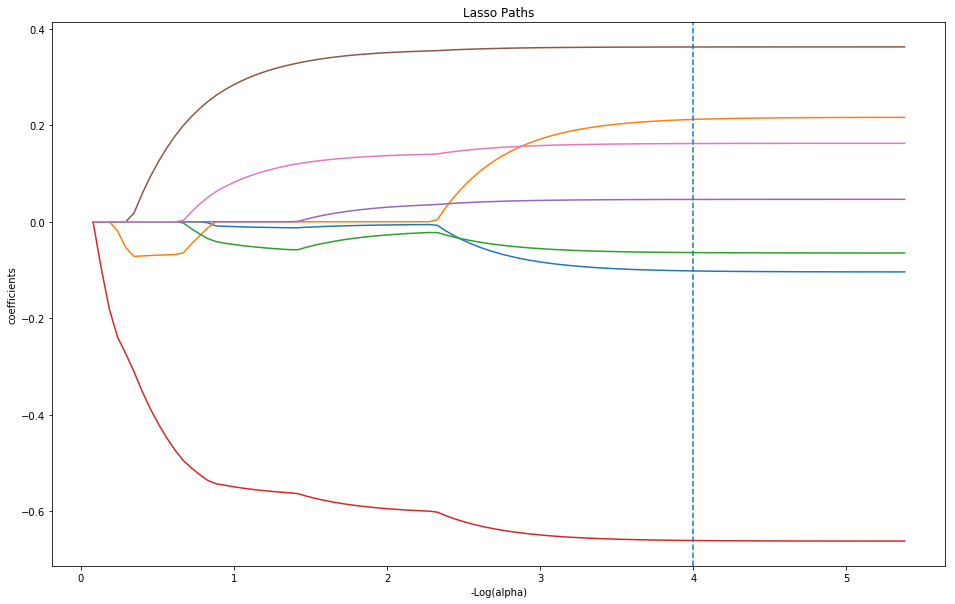

In [10]:
# use lasso path to compute alphas and corresponding coefs
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(train_x, train_y, eps=5e-6)

# plotting stuff
fig, ax = plt.subplots(figsize=[16,10])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    ax.plot(neg_log_alphas_lasso, coef_l.T)

ax.axvline(x=-np.log10(best_lamb), linestyle="--")
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Paths')
plt.axis('tight')
plt.show()